In [1]:
%cd ../pytorch/

/home/tony/predicting-poverty/pytorch


In [ ]:
% matplotlib inline
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.autograd import Variable
from torchvision import transforms
from load_dataset import BangladeshDataset, IndiaDataset
from sklearn import metrics

In [165]:
folder_name = "bangladesh_s1_2015_l2_1"
sat_type = "Sentinel-1"

Loss plots

In [166]:
losses = {
  "train": np.load("/home/tony/models/{}/losses_train.npy".format(folder_name)),
  "val": np.load("/home/tony/models/{}/losses_val.npy".format(folder_name))
}
rsq = {
  "train": np.load("/home/tony/models/{}/rsq_train.npy".format(folder_name)),
  "val": np.load("/home/tony/models/{}/rsq_val.npy".format(folder_name))
}

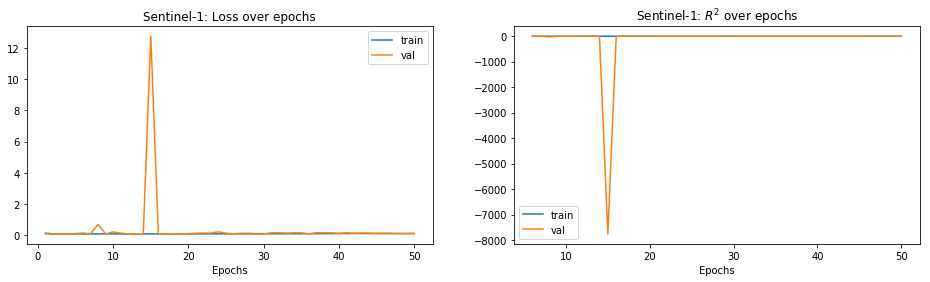

In [167]:
N = len(np.array(losses["train"]))
rsq_cutoff = 5
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, N+1), np.array(losses["train"]), label="train")
plt.plot(np.arange(1, N+1), np.array(losses["val"]), label="val")
plt.title("{}: Loss over epochs".format(sat_type))
plt.xlabel("Epochs")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(np.arange(rsq_cutoff + 1, len(rsq["train"]) + 1), np.array(rsq["train"])[rsq_cutoff:], label="train")
plt.plot(np.arange(rsq_cutoff + 1, len(rsq["val"]) + 1), np.array(rsq["val"])[rsq_cutoff:], label="val")
plt.title("{}: $R^2$ over epochs".format(sat_type))
plt.xlabel("Epochs")
plt.legend()

In [168]:
np.argmax(rsq["val"]), np.max(rsq["val"])

(35, -0.0072532681550341316)

Predicted versus observed plot.

In [169]:
import seaborn as sns

In [170]:
y_pred = np.load("/home/tony/models/{}/y_pred.npy".format(folder_name))
y_valid = np.load("/home/tony/models/{}/y_true.npy".format(folder_name))

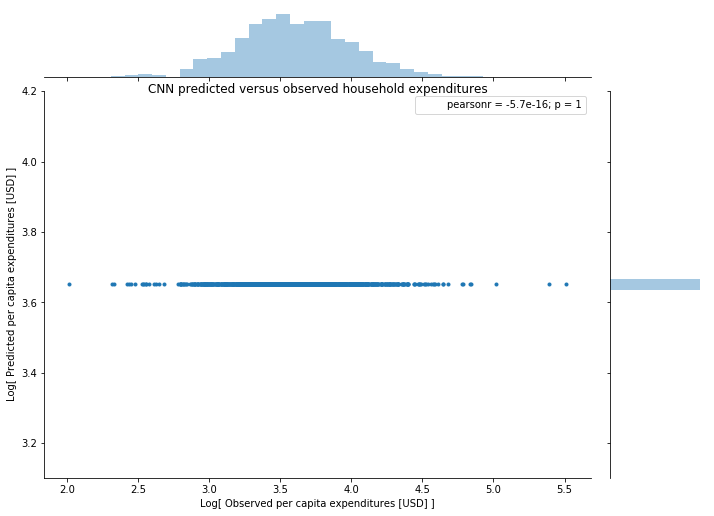

In [171]:
fig = sns.jointplot(np.log(y_valid[np.logical_and(y_valid > 0, y_pred > 0)]), 
                    np.log(y_pred[np.logical_and(y_valid > 0, y_pred > 0)]), 
                    size=8, marker=".")
fig.fig.set_size_inches((10, 7))
fig.ax_joint.set(ylabel="Log[ Predicted per capita expenditures [USD] ]",
                 xlabel="Log[ Observed per capita expenditures [USD] ]")
fig.ax_joint.set_title("CNN predicted versus observed household expenditures", y=0.98);

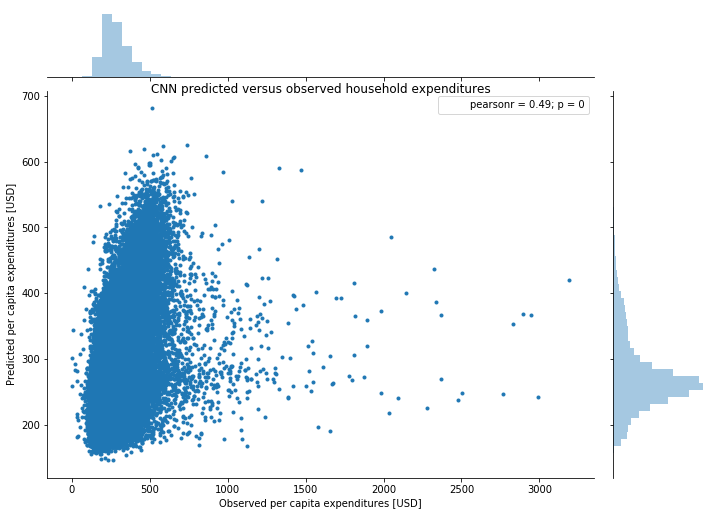

In [16]:
fig = sns.jointplot(y_valid[np.logical_and(y_valid > 0, y_pred > 0)], 
                    y_pred[np.logical_and(y_valid > 0, y_pred > 0)], 
                    size=8, marker=".")
fig.fig.set_size_inches((10, 7))
fig.ax_joint.set(ylabel="Predicted per capita expenditures [USD]",
                 xlabel="Observed per capita expenditures [USD]")
fig.ax_joint.set_title("CNN predicted versus observed household expenditures", y=0.98);

In [762]:
metrics.r2_score(y_valid, y_pred)

0.22080309951228116

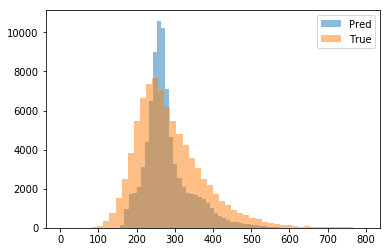

In [17]:
plt.hist(y_pred[y_pred < 800], bins=50, alpha=0.5, label="Pred")
plt.hist(y_valid[y_valid < 800], bins=50, alpha=0.5, label="True")
plt.legend();

In [172]:
model = None

In [173]:
model = torchvision.models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 1)

In [174]:
model.load_state_dict(torch.load("/home/tony/models/{}/saved_model.model".format(folder_name)))

In [175]:
model.train(False);

In [176]:
train_csv_path = "../data/india_train.csv"
val_csv_path = "../data/india_valid.csv"

In [177]:
data_transforms = {
        "train": transforms.Compose([
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        "val": transforms.Compose([
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

In [24]:
home_dir = os.path.expanduser("~")

In [25]:
val_data_dir = "{}/tiffs".format(home_dir)

In [26]:
val_dataset = IndiaDataset(csv_file=val_csv_path,
                      root_dir=val_data_dir,
                      transform=data_transforms["val"],
                      sat_type="s1")

In [27]:
len(val_dataset)

84673

In [28]:
finalconv_name = 'layer4'

In [29]:
# hook the feature extractor
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

model._modules.get(finalconv_name).register_forward_hook(hook_feature)

In [30]:
params = list(model.parameters())
weight_softmax = np.squeeze(params[-2].data.numpy())

=============

In [73]:
def vis_cam(idx):
  
  img, label = val_dataset[idx]
  print("Label:\t", label)
  print("Pred:\t", model(Variable(img.unsqueeze(0))).data[0,0])
  feature_conv = features_blobs[-1]
  bz, nc, h, w = feature_conv.shape
  cam = weight_softmax.dot((feature_conv.reshape((nc, h*w))))
  cam = cam.reshape(h, w)
  cam = cam - np.min(cam)
  cam_img = cam / np.max(cam)
  cam_img = cv2.resize(cam_img, (224, 224))
  plt.imshow(cam_img)
  img_orig = ((img.numpy().transpose(1,2,0) * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]))
  plt.imshow(plt.cm.jet(1-cam_img)[:,:,:3] * 0.2 + img_orig * 0.8)
  return label

Label:	 238.742076212
Pred:	 174.35047912597656
Label:	 162.871589992
Pred:	 189.61788940429688
Label:	 307.32327144
Pred:	 283.58135986328125
Label:	 356.351189684
Pred:	 293.0905456542969
Label:	 409.522830023
Pred:	 316.2882385253906
Label:	 303.010579061
Pred:	 281.8671875
Label:	 326.404024788
Pred:	 304.2344970703125
Label:	 260.843076366
Pred:	 253.91412353515625
Label:	 195.864020939
Pred:	 269.7012634277344
Label:	 378.385266359
Pred:	 233.39178466796875
Label:	 421.29101709
Pred:	 409.360595703125
Label:	 492.059607082
Pred:	 276.52825927734375
Label:	 276.999975982
Pred:	 326.1419372558594
Label:	 253.903603695
Pred:	 338.3173522949219
Label:	 278.009676982
Pred:	 280.0467529296875
Label:	 179.515327329
Pred:	 267.39520263671875
Label:	 122.362544511
Pred:	 219.11334228515625
Label:	 256.18955689
Pred:	 291.859375
Label:	 260.765161971
Pred:	 317.6612548828125
Label:	 322.198175212
Pred:	 287.155029296875
Label:	 300.856307775
Pred:	 313.1646728515625
Label:	 225.55761047
Pr

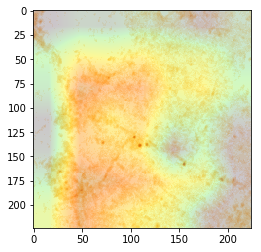

In [74]:
z = [vis_cam(i) for i in range(100)];

In [76]:
np.argmin(z), min(z)

(16, 122.36254451116241)

Label:	 122.362544511
Pred:	 219.11334228515625


122.36254451116241

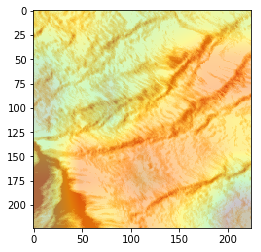

In [79]:
vis_cam(16)

In [85]:
np.argsort(z)

array([16,  1, 34, 15, 98, 31, 30, 52,  8, 49, 45, 78, 86, 77, 82, 66, 21,
       67, 83, 87, 41,  0, 80, 50, 28, 23, 74, 69, 32, 97, 13, 76, 91, 17,
       18,  7, 70, 60, 46, 62, 26, 84, 96, 12, 88, 14, 68, 72, 44, 61, 37,
       24, 73, 35, 53, 59, 20, 47, 85,  5,  2, 71, 94, 19, 40, 42, 25, 33,
        6, 51, 95, 58, 64, 27, 57, 39, 99, 79,  3, 29, 38,  9, 92, 90, 65,
       36, 93,  4, 10, 22, 43, 56, 11, 63, 48, 54, 75, 89, 81, 55])

In [148]:
16

22

Label:	 527.591957814
Pred:	 452.42034912109375


527.59195781370283

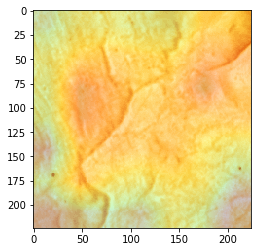

In [156]:
vis_cam(54)

Label:	 764.716428483
Pred:	 429.2021484375


764.71642848344879

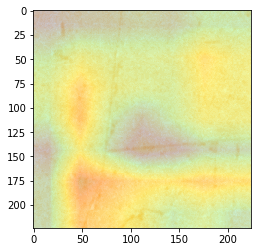

In [81]:
vis_cam(554

In [840]:
label

300.85630777521169

In [881]:
model(Variable(img.unsqueeze(0))).data[0,0]

301.74859619140625

In [842]:
feature_conv = features_blobs[-1]

In [843]:
bz, nc, h, w = feature_conv.shape

In [883]:
cam = weight_softmax.dot((feature_conv.reshape((nc, h*w))))

In [886]:
cam = cam.reshape(h, w)

In [887]:
cam = cam - np.min(cam)

In [888]:
cam_img = cam / np.max(cam)

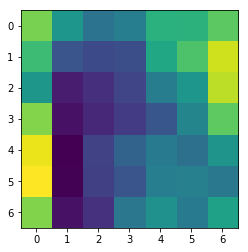

In [848]:
plt.imshow(cam_img)

In [849]:
np.uint8(cam_img * 255)

array([[203, 134,  97, 109, 163, 163, 191],
       [174,  67,  57,  61, 153, 183, 236],
       [134,  19,  34,  53, 107, 133, 229],
       [207,  12,  28,  45,  68, 116, 191],
       [247,   0,  50,  81, 104,  93, 131],
       [255,   1,  48,  67, 109, 111, 102],
       [206,  12,  36, 101, 128, 105, 145]], dtype=uint8)

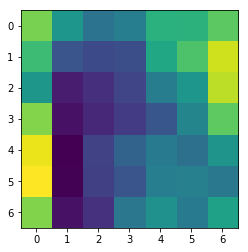

In [850]:
plt.imshow(cam_img)

In [867]:
colored = cv2.applyColorMap(np.uint8(255 * cam_img), cv2.COLORMAP_JET)

In [868]:
colored[4,4]

array([222, 255,  34], dtype=uint8)

In [876]:
(colored / 255)[0, 0]

array([ 0.        ,  0.31372549,  1.        ])

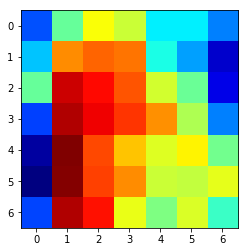

In [870]:
plt.imshow(colored / 255)

In [871]:
cam = cv2.resize(cam_img, (224, 224))

In [872]:
img_orig = ((img.numpy().transpose(1,2,0) * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]))

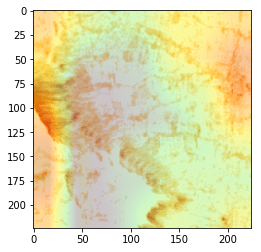

In [873]:
plt.imshow(plt.cm.jet(cam)[:,:,:3] * 0.2 + img_orig * 0.8)